<a href="https://colab.research.google.com/github/FGalvao77/Identificando-tumor-cerebral-com-deep-learning/blob/main/Identificando_tumor_cerebral_com_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='green'>**Identificando tumor cerebral c/ deep learning**</font>

---

``Redes Convolucionais``<br><br>
Uma _Rede Neural Convolucional_ (**ConvNet**) é um algoritmo de aprendizado profundo (deep learning) que pode capturar uma imagem de entrada e atribuir importâncias como pesos e vieses a vários aspectos e objetos da imagem e ser capaz de diferenciar umas das outras.




---

- Base de dados:
    - [Kaggle](https://www.kaggle.com/denizkavi1/brain-tumor)



In [1]:
# instalando as bibliotecas necessárias
!pip install opencv-python
!pip install tensorflow 

In [2]:
# importando as libs 
import os                       # para acessar recursos do sistema operacional
import cv2                      # para trabalhar com imagens
import numpy as np              # para matrizes
import matplotlib.pyplot as plt # para gráficos
import seaborn as sns           # para gráficos

import tensorflow as tf                                             # libs para deep learning
from tensorflow.keras import layers, optimizers                     # função das camadas e pesos da rede neural
from tensorflow.keras.applications import ResNet50                  # função para criar a rede convolucional
from tensorflow.keras.layers import (Input, 
                                     Dense, 
                                     AveragePooling2D, 
                                     Dropout, 
                                     Flatten)                       # funções para as camadas da rede neural
from tensorflow.keras.models import Model                           # função para criar a rede neural
from tensorflow.keras.preprocessing.image import ImageDataGenerator # função para acessar local para direcionar as imagens
from tensorflow.keras.callbacks import ModelCheckpoint              # função para salvar os pesos da rede neural

In [3]:
# acessando o google drive através do google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importando o conjunto de dados para google colab
# from google.colab import files
# uploaded = files.upload()

In [4]:
# diretório com as imagens
# diretorio_imagens = 'C:/Users/fgalvao/Desktop/archive/'
diretorio_imagens = '/content/drive/MyDrive/archive/'

# verificando as pastas presentes no diretório
print('Pastas no caminho:', os.listdir(diretorio_imagens))


Pastas no caminho: ['3', '2', '1']


In [6]:
# escalando as imagens em RGB
image_generator = ImageDataGenerator(rescale = 1.0 / 255 )

In [7]:
# preparando as imagens para serem passadas pela rede neural

# função para acessar as imagens do diretório e preparando as imagens
treino_generator = image_generator.flow_from_directory(
    batch_size = 50,                # definindo um batch para rodar 50 imagens
    directory = diretorio_imagens,  # passando o local das imagens
    shuffle = True,                 # habilitando a opção para embalharar as imagens
    target_size = (256,256),        # definindo o tamanho da imagem
    class_mode = 'categorical',     # definindo um problema de classificação
    subset = 'training'             # definindo como base de treino
)

Found 3064 images belonging to 3 classes.


In [8]:
# verificando quantos batchs serão executados
print('Temos 3064 imagens')
print('Serão executados', 3064 / 50, 'batchs')

Temos 3064 imagens
Serão executados 61.28 batchs


In [9]:
# criando os dados de treino
imagens_treino, classe_treino = next(treino_generator)

In [10]:
# verificando a dimensão
imagens_treino.shape    # 50 imagens | 256 x 256 dimensão das imagens | 3 escalas de RGB

(50, 256, 256, 3)

In [12]:
# verificando a saída da rede neural
classe_treino[0:15] # as 10 primeiras saídas

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [13]:
# criando um dicionário com as classes
classes = {
    0 : 'Meningioma',
    1 : 'Glioma',
    2 : 'Hipofisário',
}

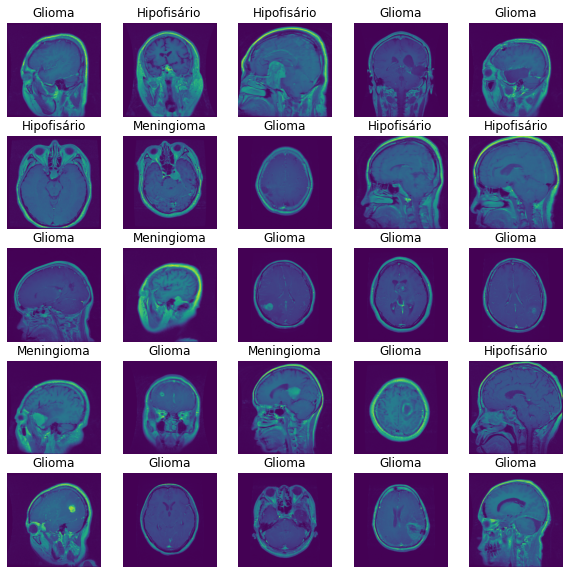

In [14]:
# plotando as imagens em uma grade de gráficos
figuras, eixos = plt.subplots(5, 5, 
                              figsize = (10,10))    # definindo o tamanho da Grade
eixos = eixos.ravel()                               # transformando uma matriz em um vetor

# loop pra plotar as imagens
for loop in np.arange(0,25):
   
    eixos[loop].imshow(imagens_treino[loop])                        # plotando as imagens no gráfico
    eixos[loop].set_title(classes[np.argmax(classe_treino[loop])])  # colocando o título nas imagens
    eixos[loop].axis('off')     # retirando o eixo da escala
    
plt.subplots_adjust(wspace=0.2) # colocando um espaço entre as imagens

In [15]:
# criando a rede neural convolucional com uma estrutura pré-treinada
modelo_basico = ResNet50( 
    weights = 'imagenet',                       # definindo o treino
    include_top = False,                        # definindo "False" para pode criar a estrutura da rede
    input_tensor = Input(shape = (256,256, 3))  # definindo o formato de entrada dos dados
)

94781440/94765736 [==============================] - 1s 0us/step


In [16]:
# verificando os dados da rede neural
modelo_basico.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [17]:
# verificando a quantidade de camadas da rede
len(modelo_basico.layers)

175

In [20]:
# congelando os pesos da rede neural
# vamos deixar as últimas camadas livres para serem treinadas
for camada in modelo_basico.layers[:-10]:
    camada.trainable = False    # cancelando o ajuste dos pesos

In [21]:
# instanciando as camadas da rede neural
modelo_inicio = modelo_basico.output                # definindo a camada de ínicio
modelo_inicio = AveragePooling2D()(modelo_inicio)   # reduzindo as dimensões

modelo_inicio = Flatten()(modelo_inicio)            # adicionando uma camada

modelo_inicio = Dense(256, 
                      activation='relu')(modelo_inicio) # adicionando os neurônios da primeira camada
modelo_inicio = Dropout(0.2)(modelo_inicio)             # adicionando o Dropout para zerar os neurônios e evitando overfiting

modelo_inicio = Dense(256, 
                      activation='relu')(modelo_inicio) # adicionando os neurônios da segunda camada
modelo_inicio = Dropout(0.2)(modelo_inicio)             # adicionando o Dropout para zerar os neurônios e evitando overfiting

modelo_inicio = Dense(3, 
                      activation='softmax')(modelo_inicio) # Definindo os neuronios de saida

In [22]:
# criando o modelo da rede neural
modelo = Model(inputs = modelo_basico.input, 
               outputs = modelo_inicio )

# configurando alguns parâmetros da rede neural
modelo.compile( 
    loss = 'categorical_crossentropy',            # função de Erro 
    optimizer = optimizers.RMSprop(lr = 1e-4, 
                                 decay = 1e-6),   # algoritimo de ajustes dos pesos
    metrics = ['accuracy']                        # métrica de avaliação
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
# treinamento da rede neural
salvando_rede = ModelCheckpoint(filepath = 'weigts.hdf5', 
                                save_best_only = True)    # salvando os dados da rede neural

# função para acessar as imagens do diretório e preparar as imagens
treino_generator = image_generator.flow_from_directory(
    batch_size = 5,                 # definindo um batch para rodar 50 imagens
    directory = diretorio_imagens,  # passando o local das imagens
    shuffle = True,                 # habilitando a opção para embalharar as imagens
    target_size = (256,256),        # definindo o tamanho da imagem
    class_mode='categorical',       # definindo um problema de classificação
    subset='training',              # definindo como base de treino
)

Found 3064 images belonging to 3 classes.


In [24]:
# rodando o modelo - iremos definir 5 épocas
'''Isso vai demorar!!!!!!'''
historico = modelo.fit_generator( 
    treino_generator,           # passando o "treino_generator"
    epochs = 5,                 # definindo as épocas - bacthes
    callbacks = [salvando_rede] # definido para salvar os pesos da redes
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
613/613 [==============================] - 903s 1s/step - loss: 0.9291 - accuracy: 0.5760
Epoch 2/5
613/613 [==============================] - 874s 1s/step - loss: 0.7417 - accuracy: 0.6619
Epoch 3/5
613/613 [==============================] - 877s 1s/step - loss: 0.6555 - accuracy: 0.7086
Epoch 4/5
613/613 [==============================] - 869s 1s/step - loss: 0.6103 - accuracy: 0.7219
Epoch 5/5
613/613 [==============================] - 863s 1s/step - loss: 0.5849 - accuracy: 0.7500


'Isso vai demorar!!!!!!'

In [25]:
# acessando o histórico da rede neural
historico.history.keys()

dict_keys(['loss', 'accuracy'])

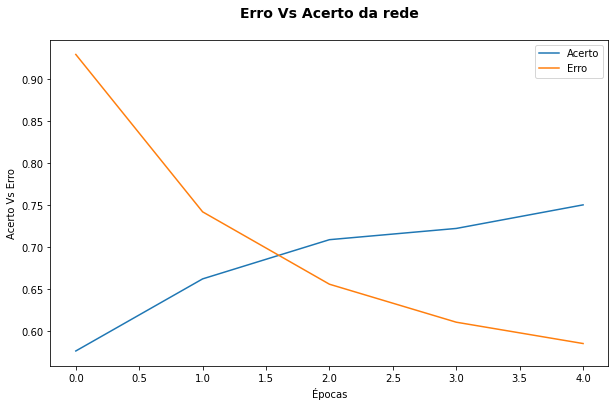

In [26]:
# plotando o erro e a acurácia do modelo
plt.figure(figsize = (10,6))                        # definindo o tamanho da figura

plt.plot(historico.history['accuracy'])             # plotando a acurácia
plt.plot(historico.history['loss'])                 # plotando o erro
plt.title('Erro Vs Acerto da rede\n', 
          {'fontsize': 14,'fontweight': 'bold'})    # definindo o título
plt.xlabel('Épocas')                                # definindo os labels
plt.ylabel('Acerto Vs Erro')
plt.legend(['Acerto', 'Erro']);                     # definindo a legenda

In [27]:
# visualizando a acurácia
historico.history['accuracy']

[0.5760443806648254,
 0.6618798971176147,
 0.7085509300231934,
 0.7219321131706238,
 0.75]

In [28]:
# visualizando o erro
historico.history['loss']

[0.9290762543678284,
 0.741690456867218,
 0.6555213332176208,
 0.6103047728538513,
 0.5849053859710693]

In [30]:
# vamos novamente rodar a rede neural
# agora iremos definir 10 épocas
'''Isso vai demorar!!!!!!'''
historico = modelo.fit_generator( 
    treino_generator,           # passando o "treino_generator"
    epochs = 10,                # definindo as épocas - bacthes
    callbacks = [salvando_rede] # definido para salvar os pesos da redes
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
613/613 [==============================] - 866s 1s/step - loss: 0.5599 - accuracy: 0.7542
Epoch 2/10
613/613 [==============================] - 864s 1s/step - loss: 0.5226 - accuracy: 0.7836
Epoch 3/10
613/613 [==============================] - 875s 1s/step - loss: 0.5281 - accuracy: 0.7846
Epoch 4/10
613/613 [==============================] - 875s 1s/step - loss: 0.5089 - accuracy: 0.7918
Epoch 5/10
613/613 [==============================] - 873s 1s/step - loss: 0.5004 - accuracy: 0.7957
Epoch 6/10
613/613 [==============================] - 869s 1s/step - loss: 0.4916 - accuracy: 0.7999
Epoch 7/10
613/613 [==============================] - 864s 1s/step - loss: 0.4768 - accuracy: 0.8133
Epoch 8/10
613/613 [==============================] - 858s 1s/step - loss: 0.4656 - accuracy: 0.8130
Epoch 9/10
613/613 [==============================] - 866s 1s/step - loss: 0.4757 - accuracy: 0.8123
Epoch 10/10
613/613 [==============================] - 868s 1s/step - loss: 0.4462 - accura

'Isso vai demorar!!!!!!'

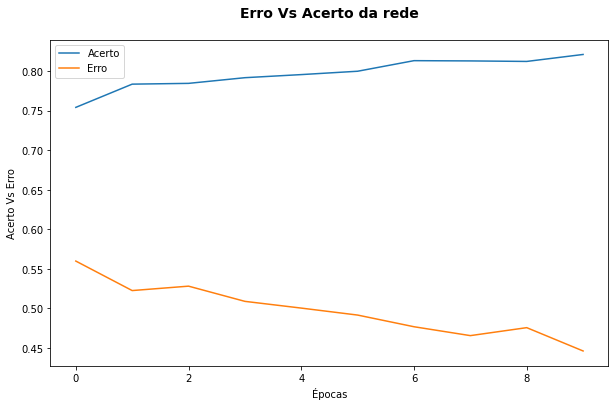

In [31]:
# plotando o erro e a acurácia do modelo
plt.figure(figsize = (10,6))                        # definindo o tamanho da figura

plt.plot(historico.history['accuracy'])             # plotando a acurácia
plt.plot(historico.history['loss'])                 # plotando o erro
plt.title('Erro Vs Acerto da rede\n', 
          {'fontsize': 14,'fontweight': 'bold'})    # definindo o título
plt.xlabel('Épocas')                                # definindo os labels
plt.ylabel('Acerto Vs Erro')
plt.legend(['Acerto', 'Erro']);                     # definindo a legenda

In [32]:
# visualizando a acurácia e o erro
historico.history['accuracy'], historico.history['loss']

([0.7542428374290466,
  0.7836161851882935,
  0.7845953106880188,
  0.7917754650115967,
  0.7956919074058533,
  0.7999347448348999,
  0.8133159279823303,
  0.8129895329475403,
  0.812336802482605,
  0.8211488127708435],
 [0.559867262840271,
  0.522563636302948,
  0.5281414985656738,
  0.5089108347892761,
  0.5003954768180847,
  0.4915735721588135,
  0.47681543231010437,
  0.465579628944397,
  0.4756545126438141,
  0.44616392254829407])